# Replicate reference asset

By: Rodrigo Hernández Mota

In this notebook a procedure for replicate a given financial asset is given. 

In [14]:
# Import libraries
% matplotlib inline

import datetime as dt
import numpy as np
import pandas as pd
import time 

from trading_session import * 
from financial_series.everything import * 
from financial_series.stationary_test import adf
from metallic_blue_lizard.neural_net import adaline

# Download prices

The time range is from ... 

In [2]:
# Determine time-range
_from, _to = '2016/01/01', dt.datetime.strftime(dt.datetime.now(),'%Y/%m/%d')

We proceed to download the information of the available stocks. 

In [3]:
# Get available stocks

# create instance of TradingSession object 
ts = TradingSession(user='sd8892',pw='Mexico0r',alias='Trading Session')

# query available stocks 
available_stocks = ts.getOptions()
print(available_stocks)

# close session
ts.close()


['AC', 'ALFA.A', 'ALSEA', 'AMX.L', 'ASUR.B', 'BIMBO.A', 'CEMEX.CPO', 'ELEKTRA', 'FEMSA.UBD', 'GAP.B', 'GCARSO.A1', 'GENTERA', 'GFINBUR.O', 'GFNORTE.O', 'GFREGIO.O', 'GMEXICO.B', 'GRUMA.B', 'ICA', 'ICH.B', 'IENOVA', 'KIMBER.A', 'KOF.L', 'LAB.B', 'LACOMER.UBC', 'LALA.B', 'LIVEPOL.C1', 'MEXCHEM', 'NAFTRAC.ISHRS', 'NEMAK.A', 'OHLMEX', 'OMA.B', 'PENOLES', 'PINFRA', 'SANMEX.B', 'SIMEC.B', 'TLEVISA.CPO', 'WALMEX']


In [4]:
available_stocks = [i for i in available_stocks if i != 'NAFTRAC.ISHRS']

In [5]:
# Create list of Stock instances.
obj = list(map(lambda x: 
               Stock(units='MXN',stock_name=yahoo_dict[x],t0=_from,tf=_to), 
               available_stocks))

# Save information in stocks dictionary 
stocks = {}
total_errors = 0
for i,j in zip(obj,available_stocks):
    print('\n- Downloading data: {}'.format(i.name()),end=' ')
    try:
        i.fill()
    except:
        print('\n\t>> Error: cannot download data: {}\n'.format(i.name()))
        total_errors += 1
        continue
    stocks[j] = i
    print('Done.')

# print total of unavailable stock information 
del obj
print('\nTotal Errors: {}'.format(total_errors))


- Downloading data: AC.MX : (MXN) Done.

- Downloading data: ALFAA.MX : (MXN) Done.

- Downloading data: ALSEA.MX : (MXN) Done.

- Downloading data: AMXL.MX : (MXN) Done.

- Downloading data: ASURB.MX : (MXN) Done.

- Downloading data: BIMBOA.MX : (MXN) Done.

- Downloading data: CEMEXCPO.MX : (MXN) Done.

- Downloading data: ELEKTRA.MX : (MXN) Done.

- Downloading data: FEMSAUBD.MX : (MXN) 
	>> Error: cannot download data: FEMSAUBD.MX : (MXN)


- Downloading data: GAPB.MX : (MXN) Done.

- Downloading data: GCARSOA1.MX : (MXN) Done.

- Downloading data: GENTERA.MX : (MXN) Done.

- Downloading data: GFINBURO.MX : (MXN) Done.

- Downloading data: GFNORTEO.MX : (MXN) Done.

- Downloading data: GFREGIOO.MX : (MXN) Done.

- Downloading data: GMEXICOB.MX : (MXN) Done.

- Downloading data: GRUMAB.MX : (MXN) Done.

- Downloading data: ICA.MX : (MXN) Done.

- Downloading data: ICHB.MX : (MXN) Done.

- Downloading data: IENOVA.MX : (MXN) Done.

- Downloading data: KIMBERA.MX : (MXN) Done.

- Do

## Download reference asset 

For this example the mexican IPC is used. 

In [6]:
ipc = Stock(units='MXN',stock_name='^MXX',t0=_from,tf=_to)
ipc.fill()

In [7]:
stocks['reference'] = ipc

## Match dates for prices and returns 

In [8]:
def getAllPrices(dct):
    
    # get first item 
    first = list(dct.keys())[0]
    price = {first:dct[first].prices.Adj_close}
    price = pd.DataFrame(price, index=price[first].index)
    
    # get other items 
    for k in dct:
        
        if k in [first]:
            continue
        
        # calculate temporal dataframe 
        temp = {k:dct[k].prices.Adj_close}
        temp = pd.DataFrame(temp, index=temp[k].index)
        
        # concatenate
        price = pd.concat([price, temp],axis=1).dropna()
        
    return price

def getAllReturns(dct, _type='log'):
    
    prices = getAllPrices(dct)
    returns = {}
    for i in prices:
        temp = prices[i].values
        if _type == 'log':
            returns[i] = np.log(temp[1:] / temp[:-1])
        if _type == 'nor' or _type == 'simple' or _type == 'sim':
            returns[i] = temp[1:] / temp[:-1] - 1
    return pd.DataFrame(returns, index=prices.index[1:])

In [9]:
prices = getAllPrices(stocks)
returns = getAllReturns(stocks, _type='log')

In [10]:
prices.head()

,KIMBER.A,KOF.L,ELEKTRA,MEXCHEM,OHLMEX,GMEXICO.B,LALA.B,SANMEX.B,CEMEX.CPO,GAP.B,...,OMA.B,TLEVISA.CPO,reference,BIMBO.A,ICA,AC,ALFA.A,ICH.B,GFINBUR.O,IENOVA
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-04,37.72264,117.54,365.66,38.23857,17.67,35.27487,39.18,27.06721,8.76923,142.50,...,78.96,92.30,42113.699219,44.8066,3.57,100.49,33.663,54.93,29.55295,72.86
2016-01-05,37.46255,116.10,354.62,38.10028,17.81,36.00585,39.42,27.30609,8.64423,141.88,...,78.77,91.57,42041.679688,45.5530,3.58,99.54,33.913,54.70,29.20759,71.36
2016-01-06,37.69374,117.57,340.09,37.59649,17.72,35.13657,39.43,27.26016,8.62500,140.98,...,79.21,90.09,41691.191406,45.7520,3.35,100.90,33.574,53.97,28.80303,70.83
2016-01-07,37.72264,117.45,331.65,36.01598,17.31,34.58339,38.61,26.18518,7.94231,135.54,...,78.15,89.91,40661.570312,45.9611,3.15,99.58,31.389,52.58,28.14191,72.19
2016-01-08,37.23136,115.96,327.13,35.96658,17.32,33.74375,38.98,25.95549,7.47115,137.86,...,76.89,91.28,40265.371094,46.3393,3.18,99.49,30.740,52.57,28.31952,70.96


In [11]:
returns.head()

,AC,ALFA.A,ALSEA,AMX.L,ASUR.B,BIMBO.A,CEMEX.CPO,ELEKTRA,GAP.B,GCARSO.A1,...,LALA.B,MEXCHEM,OHLMEX,OMA.B,PINFRA,SANMEX.B,SIMEC.B,TLEVISA.CPO,WALMEX,reference
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-05,-0.009499,0.007399,0.008112,-0.005000,-0.022329,0.016521,-0.014357,-0.030657,-0.004360,0.012382,...,0.006107,-0.003623,0.007892,-0.002409,0.003100,0.008787,-0.011640,-0.007940,-0.004211,-0.001712
2016-01-06,0.013570,-0.010046,-0.003710,-0.019402,-0.004561,0.004359,-0.002227,-0.041837,-0.006364,-0.003258,...,0.000254,-0.013311,-0.005066,0.005570,-0.018643,-0.001683,-0.002131,-0.016295,-0.006585,-0.008372
2016-01-07,-0.013169,-0.067294,-0.038930,-0.034665,-0.005422,0.004560,-0.082461,-0.025130,-0.039351,-0.033476,...,-0.021016,-0.042948,-0.023410,-0.013472,-0.015386,-0.040233,-0.022655,-0.002000,-0.058047,-0.025006
2016-01-08,-0.000904,-0.020893,-0.003343,-0.037741,-0.004163,0.008195,-0.061155,-0.013723,0.016972,-0.000587,...,0.009537,-0.001373,0.000578,-0.016254,-0.019607,-0.008810,0.003812,0.015123,0.025674,-0.009792
2016-01-11,0.012982,0.017702,0.018855,0.021740,-0.008424,0.016189,0.007693,0.037028,0.008307,0.054847,...,-0.000257,0.022540,-0.022184,0.007386,0.021587,-0.021830,-0.003266,0.014465,0.040598,0.010906


## Determine portfolio via linear regression

In [12]:
base_stocks = [i for i in returns.columns if i != 'reference']

In [13]:
replicator = adaline(x_data=returns[base_stocks], y_data=returns[['reference']])
replicator.train()
replicator.evaluate()

In [14]:
estimated_returns = [np.asscalar(i) for i in replicator.y_estimate]
real_values = [np.asscalar(i) for i in replicator.y_data.values]

In [15]:
core = {'estimation':estimated_returns,'real':real_values}

results = pd.DataFrame(core,index=replicator.y_data.index)

results.apply(lambda x: (x['real']-x['estimation'])**2,1).mean()


3.3897583685490615e-06

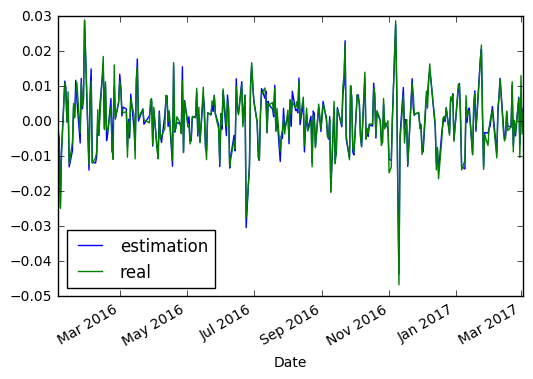

In [16]:
results.plot()

In [17]:
weights = []
for w,n in zip(replicator.w,['cash']+base_stocks):
    if n != 'cash':
        weights.append(np.asscalar(w))
    print('{} \t: {:0.4f}'.format(n,100*np.asscalar(w)))

cash 	: -0.0104
AC 	: 1.5071
ALFA.A 	: 2.2857
ALSEA 	: 0.0135
AMX.L 	: 11.6983
ASUR.B 	: 4.4170
BIMBO.A 	: 4.4155
CEMEX.CPO 	: 6.2786
ELEKTRA 	: 0.7131
GAP.B 	: 2.3595
GCARSO.A1 	: 1.3435
GENTERA 	: -0.4313
GFINBUR.O 	: -0.1760
GFNORTE.O 	: 9.4800
GFREGIO.O 	: 0.7257
GMEXICO.B 	: 7.3921
GRUMA.B 	: 3.1808
ICA 	: 0.0819
ICH.B 	: 0.1170
IENOVA 	: 2.1899
KIMBER.A 	: 3.6160
KOF.L 	: 6.5463
LAB.B 	: -0.4497
LALA.B 	: 1.1938
MEXCHEM 	: 1.6814
OHLMEX 	: 0.4859
OMA.B 	: 2.4684
PINFRA 	: 0.7606
SANMEX.B 	: 2.5524
SIMEC.B 	: -1.3455
TLEVISA.CPO 	: 7.8460
WALMEX 	: 11.7537


Iterate over the procedure to generate weight with the desired constraints (positive and sum to 1).

In [18]:
def iterativeModel(returns,base_stocks=None,weights=None,tolerance=0.005,max_iter=1000):
    condition = True
    warning = 0
    while(condition):
        
        if base_stocks is None:
            base_stocks = [i for i in returns.columns if i != 'reference']

        # get base stocks 
        if weights is not None:
            base_stocks = [s for s,b in zip(base_stocks,list(map(lambda x: x>0,weights))) if b]

        # model 
        replicator = adaline(x_data=returns[base_stocks], y_data=returns[['reference']])
        replicator.train()
        replicator.evaluate()

        # get estimations 
        estimated_returns = [np.asscalar(i) for i in replicator.y_estimate]
        real_values = [np.asscalar(i) for i in replicator.y_data.values]

        # calculate sme error 
        core = {'estimation':estimated_returns,'real':real_values}
        results = pd.DataFrame(core,index=replicator.y_data.index)
        mse = results.apply(lambda x: (x['real']-x['estimation'])**2,1).mean()

        # weights 
        weights = []
        for w,n in zip(replicator.w,['cash']+base_stocks):
            if n != 'cash':
                weights.append(np.asscalar(w))

        condition_1 = True if (False not in (list(map(lambda x: x>0,weights)))) else False 
        condition_2 = True if (sum(weights) > 1-tolerance) or (sum(weights) < 1+tolerance) else False
        condition = False if (condition_1 and condition_2) else True
        
        if warning > max_iter:
            print('Error: more than {} iterations and not solution found.')
            print('>> Change "max_iter" or "tolerance".')
            break 
        
    return {'results':results,'x_data':replicator.x_data,'mse':mse,
            'y_data':replicator.y_data,'w':weights,'stocks':base_stocks}

In [19]:
res = iterativeModel(returns)

print('Mean-Square-Error: {}'.format(res['mse']))

Mean-Square-Error: 3.419220269598198e-06


In [20]:
for w,n in zip(res['w'],['cash']+res['stocks']):
    print('\nStock name: {}\nWeight: {:0.4f}%\n'.format(n,100*w))


Stock name: cash
Weight: 1.6114%


Stock name: AC
Weight: 2.0324%


Stock name: ALFA.A
Weight: 11.7996%


Stock name: AMX.L
Weight: 4.4210%


Stock name: ASUR.B
Weight: 4.3446%


Stock name: BIMBO.A
Weight: 6.1165%


Stock name: CEMEX.CPO
Weight: 0.5134%


Stock name: ELEKTRA
Weight: 2.2665%


Stock name: GAP.B
Weight: 1.2656%


Stock name: GCARSO.A1
Weight: 9.5806%


Stock name: GFNORTE.O
Weight: 0.7231%


Stock name: GFREGIO.O
Weight: 7.3584%


Stock name: GMEXICO.B
Weight: 3.1458%


Stock name: GRUMA.B
Weight: 0.0968%


Stock name: ICA
Weight: 2.2698%


Stock name: IENOVA
Weight: 3.5514%


Stock name: KIMBER.A
Weight: 6.5867%


Stock name: KOF.L
Weight: 1.0956%


Stock name: LALA.B
Weight: 1.6937%


Stock name: MEXCHEM
Weight: 0.4683%


Stock name: OHLMEX
Weight: 2.4256%


Stock name: OMA.B
Weight: 0.5687%


Stock name: PINFRA
Weight: 2.5222%


Stock name: SANMEX.B
Weight: 7.8252%


Stock name: TLEVISA.CPO
Weight: 11.6925%



## Trade in the app 

### Kick-off 

In [21]:
initial_cash = 2000000 - 10000

In [22]:
cash = []
nstocks = []
for w,n in zip(res['w'],res['stocks']):
    
    p = prices[res['stocks']][n].iloc[-1]
    cash.append(initial_cash*w)
    nstocks.append(int(cash[-1]/p))
    
    print('\nName: {}\n>> Weight: {:0.4f}%\n>> Stocks: {} '.format(n,100*w,nstocks[-1]))


Name: AC
>> Weight: 1.6114%
>> Stocks: 278 

Name: ALFA.A
>> Weight: 2.0324%
>> Stocks: 1532 

Name: AMX.L
>> Weight: 11.7996%
>> Stocks: 17965 

Name: ASUR.B
>> Weight: 4.4210%
>> Stocks: 279 

Name: BIMBO.A
>> Weight: 4.3446%
>> Stocks: 1841 

Name: CEMEX.CPO
>> Weight: 6.1165%
>> Stocks: 7056 

Name: ELEKTRA
>> Weight: 0.5134%
>> Stocks: 34 

Name: GAP.B
>> Weight: 2.2665%
>> Stocks: 258 

Name: GCARSO.A1
>> Weight: 1.2656%
>> Stocks: 286 

Name: GFNORTE.O
>> Weight: 9.5806%
>> Stocks: 1909 

Name: GFREGIO.O
>> Weight: 0.7231%
>> Stocks: 136 

Name: GMEXICO.B
>> Weight: 7.3584%
>> Stocks: 2328 

Name: GRUMA.B
>> Weight: 3.1458%
>> Stocks: 234 

Name: ICA
>> Weight: 0.0968%
>> Stocks: 953 

Name: IENOVA
>> Weight: 2.2698%
>> Stocks: 524 

Name: KIMBER.A
>> Weight: 3.5514%
>> Stocks: 1850 

Name: KOF.L
>> Weight: 6.5867%
>> Stocks: 987 

Name: LALA.B
>> Weight: 1.0956%
>> Stocks: 653 

Name: MEXCHEM
>> Weight: 1.6937%
>> Stocks: 658 

Name: OHLMEX
>> Weight: 0.4683%
>> Stocks: 441 



In [3]:
# Open the trading session 
ts = TradingSession(user='sd8892',pw='Mexico0r',alias='Trading Session')
time.sleep(5)

In [37]:
def recursiveOperation(w,s):
    try:
        ts.performOperation(nature='compra',stock='{}'.format(w),number=int(s),price='mercado')
        return 1
    except:
        time.sleep(1)
        return recursiveOperation(w,s)

In [ ]:
_id = 0
recorded = []
for w,s in zip(res['stocks'],nstocks):
    
    print('\nInvesting in: {}'.format(w))
    # fill and submit
    try: 
        ts.performOperation(nature='compra',stock='{}'.format(w),number=int(s),price='mercado')
    except:
        print('>> Entering recursive download.')
        recursiveOperation(w,s)
    
    # take screenshow
    file_name = '{}_{}_{}'.format(dt.datetime.strftime(dt.datetime.today(),'%Y%m%d_%Hh%Mm%Ss'),w,_id)
    file_path = '/screenshots/{}.png'.format(file_name)
    ts.browser.get_screenshot_as_file(file_path)
    ts.browser.save_screenshot(file_path)
    _id += 1
    
    # accept
    time.sleep(4)
    try:
        ts.browser.find_element_by_xpath('//a[@id="btn-aceptar"]').click()
    except:
        continue
        
    recorded.append((w,s))
    print('Done!')

In [59]:
[i[0] for i in recorded]

['AC',
 'AMX.L',
 'ASUR.B',
 'BIMBO.A',
 'CEMEX.CPO',
 'ELEKTRA',
 'GAP.B',
 'GCARSO.A1',
 'GFNORTE.O',
 'GFREGIO.O',
 'GMEXICO.B',
 'GRUMA.B',
 'ICA',
 'IENOVA',
 'KIMBER.A',
 'KOF.L',
 'LALA.B',
 'MEXCHEM',
 'OHLMEX',
 'OMA.B',
 'PINFRA',
 'SANMEX.B',
 'ALFA.A',
 'TLEVISA.CPO']

In [66]:
ts = TradingSession(user='sd8892',pw='Mexico0r',alias='Trading Session')
time.sleep(5)

In [63]:
for w,s in zip(res['stocks'],nstocks):
    if w in [i[0] for i in recorded]:
        continue
        
    print('\nInvesting in: {}'.format(w))
    # fill and submit
    try: 
        ts.performOperation(nature='compra',stock='{}'.format(w),number=int(s),price='mercado')
    except:
        print('>> Entering recursive download.')
        recursiveOperation(w,s)
    
    # take screenshow
    file_name = '{}_{}_{}'.format(dt.datetime.strftime(dt.datetime.today(),'%Y%m%d_%Hh%Mm%Ss'),w,_id)
    file_path = '/screenshots/{}.png'.format(file_name)
    ts.browser.get_screenshot_as_file(file_path)
    ts.browser.save_screenshot(file_path)
    _id += 1
    
    # accept
    time.sleep(4)
    try:
        ts.browser.find_element_by_xpath('//a[@id="btn-aceptar"]').click()
    except:
        continue
        
    recorded.append((w,s))
    print('Done!')


Investing in: WALMEX
>> Entering recursive download.
Done!


In [65]:
ts.close()

In [ ]:
np.save('reference_.npy',list(zip(res['stocks'],nstocks)))

In [68]:
list(zip(res['stocks'],nstocks))

[('AC', 274),
 ('ALFA.A', 1506),
 ('ALSEA', 3),
 ('AMX.L', 17936),
 ('ASUR.B', 279),
 ('BIMBO.A', 1840),
 ('CEMEX.CPO', 7039),
 ('ELEKTRA', 33),
 ('GAP.B', 259),
 ('GCARSO.A1', 282),
 ('GFNORTE.O', 1903),
 ('GFREGIO.O', 137),
 ('GMEXICO.B', 2330),
 ('GRUMA.B', 234),
 ('ICA', 913),
 ('IENOVA', 526),
 ('KIMBER.A', 1844),
 ('KOF.L', 987),
 ('LALA.B', 641),
 ('MEXCHEM', 712),
 ('OHLMEX', 446),
 ('OMA.B', 492),
 ('PINFRA', 61),
 ('SANMEX.B', 1679),
 ('TLEVISA.CPO', 1543),
 ('WALMEX', 5960)]

## Save changes 

In [21]:
# Open the trading session 
ts = TradingSession(user='sd8892',pw='Mexico0r',alias='Trading Session')
time.sleep(5)

In [ ]:
a = ts.browser.find_element_by_xpath('//table[@class="zebra_stripes width_100_percent mb_30"]').text

In [15]:
save_first = {1:a}

In [18]:
np.save('save_index_changes.npy',save_first)

In [20]:
np.load('save_index_changes.npy').item()

{1: 'Fecha y Hora Transacción Emisora Volumen Precio\n($) Importe\nTotal ($) Efectivo\nDisponible($)\n  06 mar 2017 08:30:00 Compra Realizada GMEXICO.B 100 62.890 6,311.01 1,931,635.25\n06 mar 2017 08:30:00 Compra Realizada ICA 531 2.040 1,087.03 1,877,124.25\n06 mar 2017 08:30:00 Compra Realizada GMEXICO.B 551 62.890 34,773.67 1,896,861.62\n06 mar 2017 08:30:00 Compra Realizada ICA 422 2.040 863.89 1,876,260.38\n06 mar 2017 08:30:00 Compra Realizada IENOVA 100 87.760 8,806.72 1,867,453.62\n06 mar 2017 08:30:00 Compra Realizada GMEXICO.B 100 62.890 6,311.01 1,890,550.62\n06 mar 2017 08:30:00 Compra Realizada ELEKTRA 5 294.150 1,475.90 1,889,074.75\n06 mar 2017 08:30:00 Compra Realizada CEMEX.CPO 116 17.220 2,004.51 1,881,114.38\n06 mar 2017 08:30:00 Compra Realizada GRUMA.B 98 267.350 26,292.00 1,801,190.25\n06 mar 2017 08:30:00 Compra Realizada ASUR.B 13 315.000 4,109.33 1,561,111.00\n06 mar 2017 08:30:00 Compra Realizada GCARSO.A1 286 87.930 25,236.00 1,974,764.00\n06 mar 2017 08:30:

## Save portfolio value

In [26]:
value = ts.browser.find_element_by_xpath('//span[@class="float_right"]').text

In [31]:
date = dt.datetime.strftime(dt.datetime.now(),'%Y/%m/%d')

In [32]:
np.save('index_value.npy',{1:{'date':date,'value':value}})

In [33]:
np.load('index_value.npy').item()

{1: {'date': '2017/03/06', 'value': '$ 2,020,364.50'}}

In [36]:
np.max(list(np.load('index_value.npy').item().keys()))

1

## Test

In [1]:
% matplotlib inline
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt

In [6]:
log = np.load('index_value.npy').item()

In [8]:
date = []
val  = []
for k in log:
    date.append(log[k]['date'])
    val.append(log[k]['value'])

In [9]:
def str2float(string):
    return np.float(''.join([i for i in string.strip('$').strip(' ') if i != ',']))

def str2date(string):
    return dt.datetime.strptime(string,'%Y/%m/%d')

In [15]:
df = pd.DataFrame({'Date':list(map(str2date,['2017/03/07']+date)),'Value':list(map(str2float,['2000000']+val))})
df

,Date,Value
0,2017-03-07,2000000.00
1,2017-03-08,2001828.38
2,2017-03-08,2004188.88
3,2017-03-09,1990262.00
4,2017-03-12,1981453.38
5,2017-03-13,1982594.25
6,2017-03-15,1995187.25
7,2017-03-16,2020236.62
8,2017-03-20,2045074.00
9,2017-03-20,2045074.00


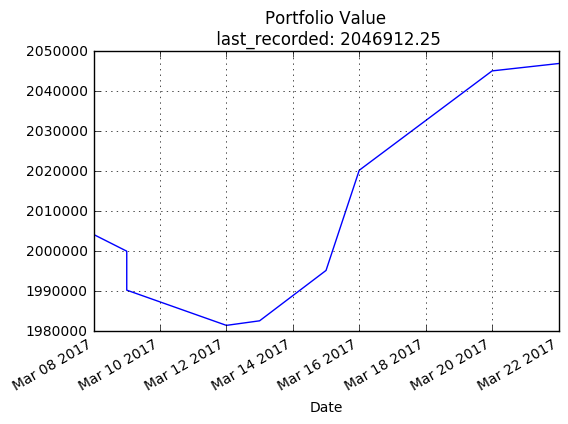

In [13]:
df.plot(x='Date',y='Value',legend=False)
plt.grid(True)
plt.title('Portfolio Value\n last_recorded: {}'.format(df.Value.iloc[-1]))

In [33]:
df.index = df.Date

In [18]:
def scaleValues(y):
    y_max = np.max(y)
    return y / y_max

In [16]:
# Determine time-range
_from, _to = '2017/03/07', dt.datetime.strftime(dt.datetime.now(),'%Y/%m/%d')
ipc = Stock(units='MXN',stock_name='^MXX',t0=_from,tf=_to)
ipc.fill()

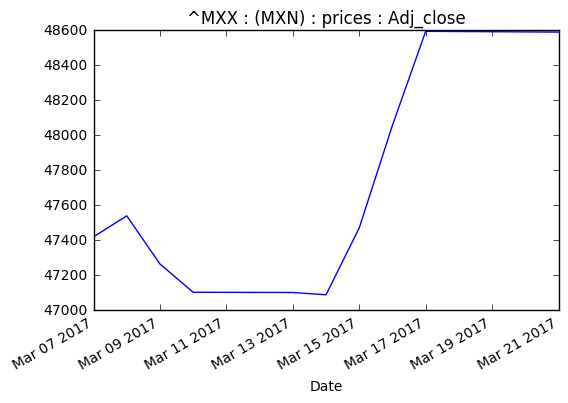

In [17]:
ipc.plot()

In [ ]:
# get same dates 

In [31]:
refdates = list(ipc.prices.loc[df.Date].dropna().index)

In [37]:
ipc_df = ipc.prices.loc[refdates][['Adj_close']]

In [36]:
df = df.loc[refdates]

In [44]:
df_temp = df.copy()
df_temp['Value'] = scaleValues(df.Value)

In [64]:
def getReturns(x):
    return x[1:]/x[:-1] -1


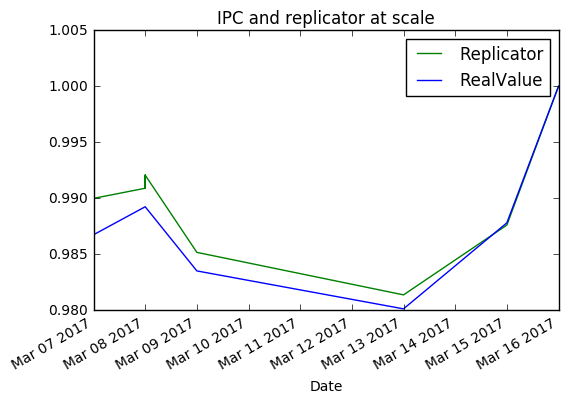

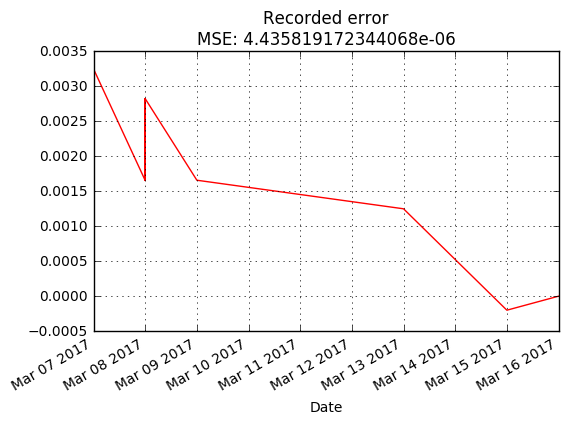

Sharpe: 0.0003823484535764505


In [66]:
#plt.plot(df.index,scaleValues(df.Value),'r')
df_temp.plot(c='g')
plt.plot(ipc_df.index,scaleValues(ipc_df.Adj_close),'b')
plt.legend(['Replicator','RealValue'])
plt.title('IPC and replicator at scale')
plt.show()

temp = (df_temp.Value - scaleValues(ipc_df.Adj_close))
sharpe = (np.mean(getReturns(df_temp.Value))-np.mean(getReturns(ipc_df.Adj_close))) / np.std(getReturns(df_temp.Value))
temp.plot(c='r')
plt.title('Recorded error\nMSE: {}'.format(temp.apply(lambda x: x**2).mean()))
plt.grid(True)
plt.show()
print('Sharpe: {}'.format(sharpe))

In [67]:
log_ = np.load('reference_.npy')

In [71]:
cont = 1
for i in log_:
    sep = '\t' if cont%5 else '\n'
    print(i,sep)
    cont += 1

['AC' '274'] 	
['ALFA.A' '1506'] 	
['ALSEA' '3'] 	
['AMX.L' '17936'] 	
['ASUR.B' '279'] 

['BIMBO.A' '1840'] 	
['CEMEX.CPO' '7039'] 	
['ELEKTRA' '33'] 	
['GAP.B' '259'] 	
['GCARSO.A1' '282'] 

['GFNORTE.O' '1903'] 	
['GFREGIO.O' '137'] 	
['GMEXICO.B' '2330'] 	
['GRUMA.B' '234'] 	
['ICA' '913'] 

['IENOVA' '526'] 	
['KIMBER.A' '1844'] 	
['KOF.L' '987'] 	
['LALA.B' '641'] 	
['MEXCHEM' '712'] 

['OHLMEX' '446'] 	
['OMA.B' '492'] 	
['PINFRA' '61'] 	
['SANMEX.B' '1679'] 	
['TLEVISA.CPO' '1543'] 

['WALMEX' '5960'] 	
